# Welcome to our Scalable Rapid Twitter Topic Detection Framework

In [177]:
import warnings
warnings.filterwarnings("ignore") #Only added this to shorten the notebook output
# Must use Python 3.7 due to some packages not being supported after 3.7
import re
import string
from itertools import islice
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import emoji # python3 -m pip install emoji --upgrade
from nltk.tokenize import RegexpTokenizer
# run the following if you get an SSL error
# "/Applications/Python 3.10/Install Certificates.command"
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt 
import spacy
import gensim
from spacy.tokenizer import Tokenizer
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS as SW
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from gensim.test.utils import common_texts
from wordcloud import WordCloud
import pyLDAvis
import pyLDAvis.sklearn

### 1. Loading the raw data

In [178]:
start_time = time.perf_counter()

df = pd.read_csv('data/processed.csv')
print(df.shape)
print(df.columns)
print(df.head())

(237487, 2)
Index(['labels', 'text'], dtype='object')
  labels                                               text
0    bot  @aprilPINKie Justice isn’t going anywhere right?!
1    bot  Last game at DKR in 2022! Longhorns for Christ...
2    bot  @CFBONFOX Texas goes 4-0 and makes the big 12 ...
3    bot                      @hookemcowboys It’s from 2020
4    bot  @CFBONFOX The Texas Longhorns. Nothing better ...


##### Remove non-bot (human) tweets

In [179]:
bot_tweets = df[(df['labels'] == 'bot')]
num_tweets = bot_tweets.shape[0]
print("Total Number of tweets: " + str(num_tweets))
unique_tweets = bot_tweets.text.unique().shape[0]
print("Total Number of unique tweets: " + str(unique_tweets))
print(bot_tweets.head())
bot_tweets['is_retweet'] = bot_tweets['text'].apply(lambda x: x[:2]=='RT')
num_of_retweets = bot_tweets['is_retweet'].sum() 
print("Number of retweets: " + str(num_of_retweets))  # number of retweets



Total Number of tweets: 14581
Total Number of unique tweets: 14476
  labels                                               text
0    bot  @aprilPINKie Justice isn’t going anywhere right?!
1    bot  Last game at DKR in 2022! Longhorns for Christ...
2    bot  @CFBONFOX Texas goes 4-0 and makes the big 12 ...
3    bot                      @hookemcowboys It’s from 2020
4    bot  @CFBONFOX The Texas Longhorns. Nothing better ...
Number of retweets: 30


#### Popular Hashtags
Let's take a look at the top hastags before diving into our model. This should prepare us for what to expect.

In [180]:
def find_hashtags(tweet):
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', tweet) 

bot_tweets['hashtags'] = bot_tweets['text'].apply(find_hashtags)

hashtags = bot_tweets.loc[
                       bot_tweets.hashtags.apply(
                           lambda hashtags_list: hashtags_list !=[]
                       ),['hashtags']]

individual_hashtags = pd.DataFrame(
    [hashtag for hashtags_list in hashtags.hashtags
    for hashtag in hashtags_list],
    columns=['hashtag'])
    
popularHashtags = individual_hashtags.groupby('hashtag').size()\
                                        .reset_index(name='counts')\
                                        .sort_values('counts', ascending=False)\
                                        .reset_index(drop=True)
print(popularHashtags)

                     hashtag  counts
0     #DigitalTransformation     132
1                        #AI     122
2                  #Vegaswap     119
3                #technology     113
4                    #crypto     106
...                      ...     ...
3896            #SteveBannon       1
3897         #StrangerThings       1
3898               #Streamer       1
3899                 #Stroke       1
3900            #zooplankton       1

[3901 rows x 2 columns]


### 2. Data Cleaning
Here we will tidy up the tweets. We remove hashtags, links, user mentions, punctuation, and emojis. We will also be converting those words into to their root form in the process called rooting/lemmatization. Words in the 3rd person are converted to first person and verbs in past/future tenses are changed into the present & converted into their root form.

Afterwards we will be able to covert the tweets into vectors.

In [181]:
stopWords = nltk.corpus.stopwords.words('english')
word_rooter = nltk.stem.snowball.PorterStemmer(ignore_stopwords=False).stem
#patterns
mentions_pattern =re.compile(r'@\w*')
url_pattern = re.compile(r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))'
        r'[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})')
hashtags_pattern = re.compile(r'#\w*')
reserved_words_pattern = re.compile(r'(RT|rt|FAV|fav|VIA|via)')
empty_spaces = re.compile(r'\s{2,}|\t')

In [182]:
def tweet_cleaner(text):

    text = str(text) + ""
    #set text to lowercase
    text = text.lower()

    #remove mentions
    text = re.sub(pattern=mentions_pattern, repl='', string=text)

    #remove urls
    text = re.sub(pattern=url_pattern, repl='', string=text)

    #remove links
    text = re.sub(r'http(s)?\S+', '', text)

    #remove @ tags of users
    text = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', text)  # remove retweet
    text = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', text)  # remove tweeted at
    
    #remove twitter reserved_words
    text = re.sub(pattern=reserved_words_pattern, repl='', string=text)

    #remove hashtags
    #text = re.sub(pattern=hashtags_pattern, repl='', string=text)

    #remove emojis
    text = emoji.replace_emoji(text, "")

    #remove words with less than 3 characters
    text_list = text.split(' ')
    for x in text_list:
        if len(x) <= 2:
            text_list.remove(x)
    text = ' '.join(text_list)

    #remove stopwords and apply rooting
    if len(text) > 0:
        text = "the " + text
        newText = [word for word in text.split(' ')
                            if word not in stopWords]
        newText = [word_rooter(word) if '#' not in word else word
                            for word in newText]
        text = ' '.join(newText)

    #remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation)) #this removes hashtag symbols as well
    text = re.sub('[' + '!"$%&\'’()*+,-./:;<=>?[\\]^_`{|}~•@.""-,`' + ']+', '', text)

    #remove numbers
    text_list = text.split(' ')
    for x in text_list:
        if x.isnumeric():
                text_list.remove(x)
    text = ' '.join(text_list)
    #text = re.sub('([0-9]+)', '', text)
        
    #remove words with 2 or less characters
    text_list = text.split(' ')
    for x in text_list:
        if len(x) <= 2:
            text_list.remove(x)
    text = ' '.join(text_list)

    #remove empty spaces
    text = re.sub(pattern=empty_spaces, repl=' ', string=text)
    text = re.sub('\s+', ' ', text)

    #remove empty lines
    text = re.sub('\s+', ' ', text)
    
    return text.strip()

In [183]:
bot_tweets['cleaned_bot_tweets']  = bot_tweets['text'].apply(lambda x: tweet_cleaner(x))
bot_tweets = bot_tweets[(bot_tweets['cleaned_bot_tweets'].str.len() > 2)]
print(bot_tweets.shape)
print(bot_tweets)

(13599, 5)
       labels                                               text  is_retweet  \
0         bot  @aprilPINKie Justice isn’t going anywhere right?!       False   
1         bot  Last game at DKR in 2022! Longhorns for Christ...       False   
2         bot  @CFBONFOX Texas goes 4-0 and makes the big 12 ...       False   
4         bot  @CFBONFOX The Texas Longhorns. Nothing better ...       False   
5         bot  @UTBarstool Unfortunately we don’t play for tw...       False   
...       ...                                                ...         ...   
226413    bot  @prof_mirya Why doesn’t gd give us a November ...       False   
226414    bot  @SumitaPahwa @alixabeth Absolutely lovely Xmas...       False   
226416    bot  @prof_mirya I would watch a demo of you packin...       False   
226417    bot  @prof_mirya “ Dream of living out in the woods...       False   
226418    bot                         @dannagal It’s the smolder       False   

                            

In [184]:
bot_tweets.drop(columns='text', inplace=True)
bot_tweets.drop(columns='labels', inplace=True)
print(bot_tweets.shape)
print(bot_tweets.head())

(13599, 3)
   is_retweet                      hashtags  \
0       False                            []   
1       False    [#AllGasNoBrakes, #HookEm]   
2       False  [#HOOKEM, #ALLGASNOBRAKES22]   
4       False                            []   
5       False                            []   

                                  cleaned_bot_tweets  
0                          justic isnt anywher right  
1  last game dkr longhorn christ park lot open…so...  
2  texa goe make big championship end rematch bam...  
4             texa longhorns noth better burnt orang  
5                          unfoun dont play two week  


In [185]:
###### Lets take a look at the most repeated tweets
#print("There are " + str(bot_tweets["cleaned_bot_tweets"].unique().shape[0]) + " unique tweets.")
#most_repeated_tweets = bot_tweets.groupby(['cleaned_bot_tweets']).size().reset_index(name='count').sort_values('count', ascending=False).head(10)
#print("Most repeated tweets:")
#print(most_repeated_tweets)

### 3. Topic Modelling
In this stage we will build a fitted topic model for the bot tweets. Model will be our LDA (Latent Dirichlet Allocation) algorithm model object which will holds parameters such as the number of topics that we provided it when we made it. Model also it also stores functions such as the fitting method. Once it is fit it will store fitted parameters that will tell us how valuable different words are in various topics. 

#### Creating the Model
Here we create a model using the LDA topic model algorithm. It takes in as input a document word matrix and a dictionary. Here we first create a dictionary then filter out the extremes then finally create a corpus object for which the document matrix LDA model recieves as the main input to train on.

For our model we decided to choose 10 topics for now Later, in hyperparameter tuning stage, we will be able to determine the best/optimal number of topics.

In [186]:
# about 25% of blog posts are said to be made up of stop words so we'll set max_df to 0.25. We're assuming any above was missed in the data cleaning stop words filtering.
vectorizer = CountVectorizer(max_df=0.25, min_df=0.005, token_pattern='\w+|\$[\d\.]+|\S+') # used to transform text to vector form

doc_term_matrix = vectorizer.fit_transform(bot_tweets["cleaned_bot_tweets"])

numberOfTopicsToDisplay = 15

model = LatentDirichletAllocation(n_components=numberOfTopicsToDisplay, random_state=0)

model.fit(doc_term_matrix.toarray())


LatentDirichletAllocation(n_components=15, random_state=0)

##### Printing out the topics will help us see the related words in each topic "bag" sorted by relevance.

In [187]:
# Getting the topics
num_words_per_topic = 10
feature_names = vectorizer.get_feature_names_out() # what word each column in the matric represents
topic_frame = {}
topicId_words_to_weights = {}
for topic_id, topicId_to_weights in enumerate(model.components_):
    
    topic_frame["Topic %d" % (topic_id)] = [feature_names[id]
                    for id in topicId_to_weights.argsort()[:-num_words_per_topic - 1:-1]]
    topic_frame["T%d weights" % (topic_id)]= [topicId_to_weights[id]
                    for id in topicId_to_weights.argsort()[:-num_words_per_topic - 1:-1]]

    words_to_weights = []
    
    for id in topicId_to_weights.argsort()[:-num_words_per_topic - 1:-1]:
        word = feature_names[id]
        weight = topicId_to_weights[id]
        tuple = (word, weight)
        words_to_weights.append(tuple)
    
    topicId_words_to_weights[topic_id] = words_to_weights

print("Number of topics: " + str(model.n_components))
print(pd.DataFrame(topic_frame).head())


Number of topics: 15
                Topic 0  T0 weights Topic 1  T1 weights Topic 2  T2 weights  \
0  aificialintelligence  169.066667     one  403.822558   video  319.066666   
1                  tech  169.066666     day  336.712858    free  229.066666   
2                 cloud  155.018975    hope  169.269252     lt3  217.066667   
3                 robot  132.066666     del  127.066666    view  140.066667   
4            technology  117.292988    code  124.002943   updat  136.923532   

    Topic 3  T3 weights Topic 4  T4 weights  ... Topic 10  T10 weights  \
0     paper  393.767904     new  378.358694  ...     help   172.413886   
1    accept  172.066666    year  238.333100  ...    everi   147.066666   
2      full  154.066666     see  227.624250  ...  project   146.844505   
3   science  130.066666   pleas  190.807114  ...     link   146.334307   
4  research  129.813486    look  179.821823  ...    happi   136.969255   

   Topic 11  T11 weights Topic 12  T12 weights Topic 13  T1

### 4. Visualizations

#### WordCloud
We'll use WordCloud to  visualize the top 3 topics. It will display which words are the most prevalent in varying sizes depending on how often they appear for each topic.

WordClouds for the top 3 topics: 


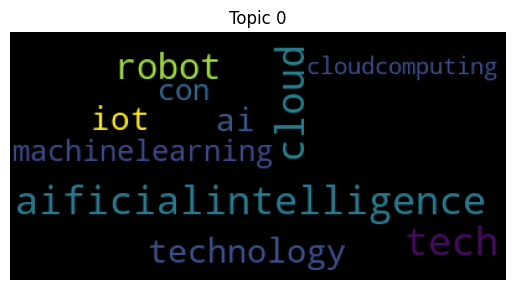

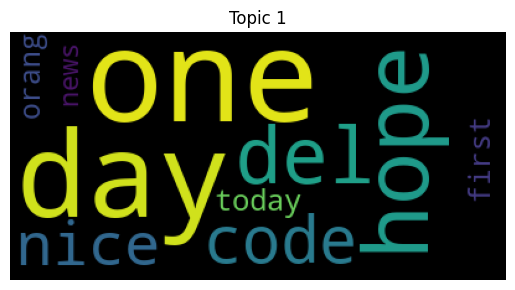

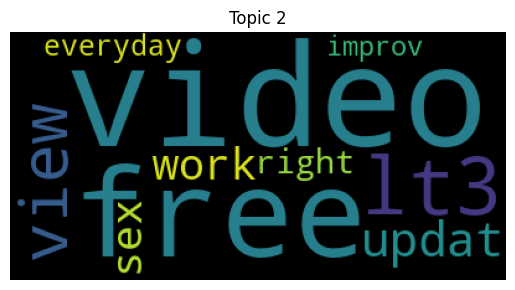

In [188]:
print("WordClouds for the top 3 topics: ")
for topicId in range(0, min(3, len(topicId_words_to_weights))):
    words_to_weights = topicId_words_to_weights[topicId]
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(words_to_weights)))
    plt.axis("off")
    plt.title("Topic " + str(topicId))
    plt.show()

#### Interactive visualization
Next we'll use the pyLDAvis package’s interactive chart to help interpret the topics. It pulls information from the LDA model for the interactive web-based visualization to use.

In [191]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(model, doc_term_matrix, vectorizer, mds='tsne')

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
4      114.344879  114.308296       1        1  9.964942
12     105.821045  -93.749626       2        1  9.857327
13    -138.334473   95.320763       3        1  8.116175
14      -7.436697  111.259697       4        1  7.947271
9     -207.550629 -105.472603       5        1  7.067951
5       52.817650   14.603765       6        1  6.631651
3      168.010849    6.806950       7        1  6.178032
1      -94.169601 -157.789551       8        1  6.162228
10    -122.849174  -39.059418       9        1  5.856146
0      -94.894264  195.408295      10        1  5.839124
7       24.927401 -180.464874      11        1  5.807400
11     -53.413467   26.832108      12        1  5.422816
6      -12.255850  -72.093201      13        1  5.312113
8     -224.217957   28.070581      14        1  5.015844
2       36.154255  209.427582      15        1  4.820980, topic_info=      Term        Freq       Total Category  logprob  loglift
18     amp  831.000000  831.000000  Default  30.0000  30.0000
274  thank  669.000000  669.000000  Default  29.0000  29.0000
298    use  555.000000  555.000000  Default  28.0000  28.0000
191    one  495.000000  495.000000  Default  27.0000  27.0000
200  paper  496.000000  496.000000  Default  26.0000  26.0000
..     ...         ...         ...      ...      ...      ...
15    also    0.073495  228.556537  Topic15 -10.3658  -5.0101
151  learn    0.073495  352.569766  Topic15 -10.3658  -5.4436
28    base    0.073495   85.834521  Topic15 -10.3658  -4.0308
250   sinc    0.073495   73.411274  Topic15 -10.3658  -3.8744
26   avail    0.073495  100.847162  Topic15 -10.3658  -4.1919

[557 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
0         7  0.990103    2022
1         5  0.254744     25k
1        13  0.734839     25k
2        13  0.986675      3k
3         7  0.997510  accept
...     ...       ...     ...
328       6  0.997718     you
329       9  0.127260       ”
329      14  0.869612       ”
330      11  0.095091       …
330      13  0.899046       …

[1029 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 13, 14, 15, 10, 6, 4, 2, 11, 1, 8, 12, 7, 9, 3])

In [190]:
print("Program run time: " + str(int((time.perf_counter() - start_time))) + " seconds.")

Program run time: 33 seconds.
